In [185]:
"""Multi-Agent model.

author: Martino Ferrari
"""
import sys

import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl 

mpl.rcParams['figure.figsize']=(9.0,6.0)    #(6.0,4.0)
mpl.rcParams['font.size']=12                #10 
mpl.rcParams['savefig.dpi']=300             #72 
mpl.rcParams['figure.subplot.bottom']=.1    #.125

def __randir__():
    di = rnd.rand(2)-0.5
    return di/np.linalg.norm(di)




def __density__(pos, center):
    return 1.0/(1+np.linalg.norm(pos-center))

def __uni_density__(pos, center):
    d = np.linalg.norm(pos-center)
    return 1 if d < 1.5 else 0


def __init_bacteria__(N, size):
    posx = 2*size*(rnd.rand(N)-0.5)
    posy = 2*size*(rnd.rand(N)-0.5)
    return [Agent(np.array([px, py])) for (px, py) in zip(posx, posy)]


def __plot__(agents):
    xs = np.zeros(len(agents))
    ys = np.zeros(len(agents))
    for i in range(0, len(agents)):
        xs[i] = agents[i].pos[0]
        ys[i] = agents[i].pos[1]
    plt.scatter(xs, ys, color='C1')




## Implementation

In this TP we will implement a simple multi-agent model of a bacteria. The bacteria at each iteration can continue on its direction or randomly change direction.   
The probability of each behaviours depends from the density of nutriment on its position.

To model this agent I choose to use a simple class:

In [308]:
class Agent:
    """Bacterial agent."""
    def __init__(self, pos):
        self.pos = np.array(pos)
        self.speed = 2 # 20 um/s
        self.direction = __randir__()
        self.density = 0
        self.alpha = 0.1

    def move(self, dt):
        """Move bacteria."""
        self.pos += self.speed * dt * self.direction
    
    def n_move(self, agents, dt):
        """Move bacteria in function of neighbours."""
        center = np.zeros(2)
        counter = 0
        for a in agents:
            if a != self:
                d = np.linalg.norm(a.pos-self.pos)
                if (d < 1.0):
                    center += a.pos
                    counter += 1
        if counter > 0:
            center /= counter
            speed = self.speed*self.direction + self.alpha*(self.pos-center)
        else:
            speed = self.speed*self.direction
        self.pos += speed * dt
        
    def update(self, density):
        """Update direction."""
        p = 0.9 if density > self.density else 0.5
        self.density = density
        if rnd.rand() > p:
            self.direction = __randir__()
  

## Results

In this section I will comment the results of different experiment I did.

### Continuos density

First to be able to update the batteria we need to define the nutriment density in function of the position. In this first part I will consider the following:

$$\rho(\bar{x}) =\frac{1}{1+|\bar{x}-\bar{c}|}$$

where $\bar{x}$ is the current position and $\bar{c}$ is the center of the simulation.



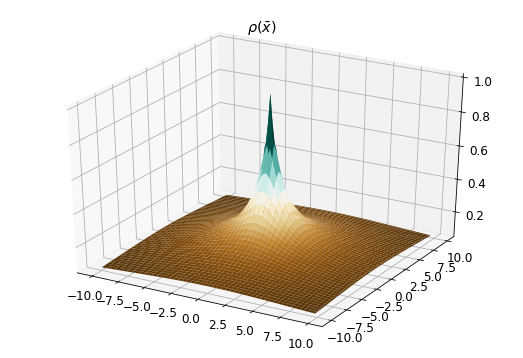

In [273]:
__CENTER__ = np.array([0, 0])
N = 100
DS = __SIZE__*2/(N)
FOOD = np.zeros([N, N])
for i in range(N):
    x = i*DS-__SIZE__
    for j in range(N):
        y = j*DS-__SIZE__
        FOOD[i, j] = __density__([x, y], __CENTER__)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X = np.arange(-__SIZE__, __SIZE__, DS)
Y = np.arange(-__SIZE__, __SIZE__, DS)

X, Y = np.meshgrid(X, Y)
ax.plot_surface(X,Y,FOOD, cmap='BrBG')
plt.title(r'$\rho(\bar{x})$')
plt.show()

### 1 Bacteria Itinerary

The first experience we were asked to do is to draw the itinerary of a single bacteria in our simulation, after 30 iterations the results is the following: 


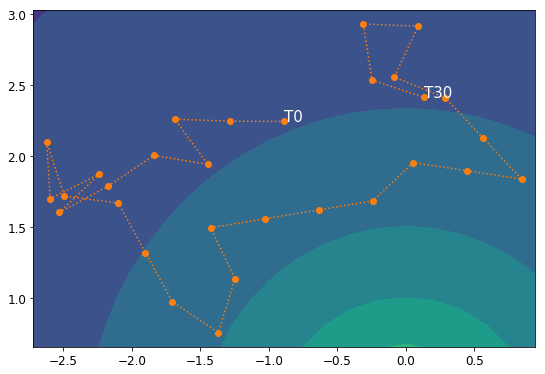

In [241]:
posx = 2*__SIZE__*(rnd.rand()-0.5)
posy = 2*__SIZE__*(rnd.rand()-0.5)
bact = Agent(np.array([posx, posy]))

__ITER__ = 30

xs = []
ys = []
for it in range(0, __ITER__):
    bact.move(__DT__)
    bact.update(__density__(ag.pos, __CENTER__))
    xs.append(bact.pos[0])
    ys.append(bact.pos[1])
        
plt.contourf(X,Y,FOOD, 10)
plt.plot(xs,ys,'o:', color='C1')
plt.xlim([np.min(xs)-0.1, np.max(xs)+0.1])
plt.ylim([np.min(ys)-0.1, np.max(ys)+0.1])
plt.text(xs[0],ys[0], 'T0', color='white',fontsize=15)
plt.text(xs[-1],ys[-1], 'T{}'.format(__ITER__), color='white',fontsize=15)
plt.show()

It's interesting to see how the bectaria in our simulation moves at a constant speed, and how it's somehow attracted by the nutriment (as the probability of direction change is smaller).

### 100 Bacterias

In this experiment we were asked to analyze a simulation with 100 bacterias, the first experimentation I did was to see how the population evolve during the time (100 iterations, 20s):

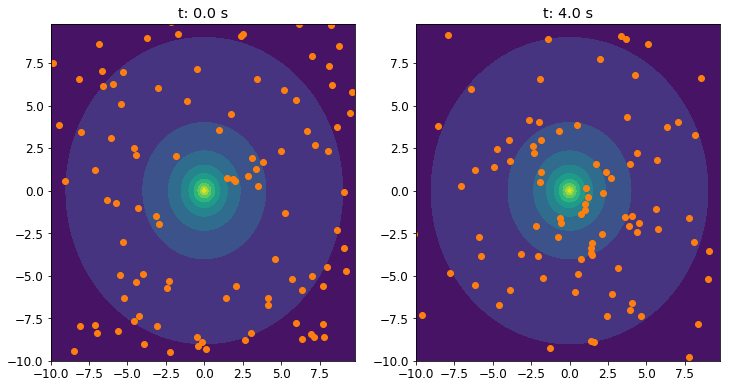

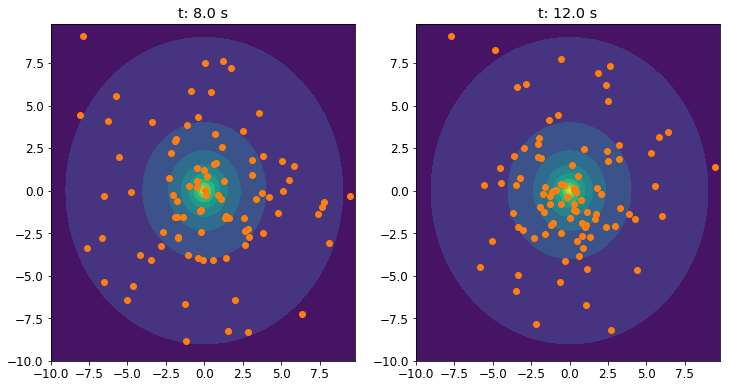

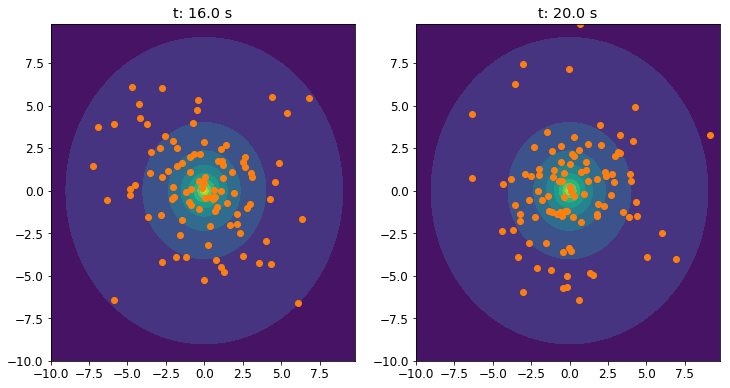

In [282]:
mpl.rcParams['figure.figsize']=(12.0,6.0)    #(6.0,4.0)


__NBACT__ = 100
__ITER__ = 100
__SIZE__ = 10
__DT__ = 0.2

AGENTS = __init_bacteria__(__NBACT__, __SIZE__)

plt.figure()
plt.subplot(121)
plt.contourf(X,Y,FOOD, 10)
__plot__(AGENTS)
plt.xlim([np.min(X), np.max(X)])
plt.ylim([np.min(Y), np.max(Y)])
plt.title("t: 0.0 s")

for it in range(0, __ITER__):
    for ag in AGENTS:
        ag.move(__DT__)
        ag.update(__density__(ag.pos, __CENTER__))

        
    if (it+1)%20 == 0: 
        if  (it+1)/20 % 2:
            plt.subplot(122)
        else:
            plt.figure()
            plt.subplot(121)
        plt.contourf(X,Y,FOOD, 10)
        __plot__(AGENTS)
        plt.xlim([np.min(X), np.max(X)])
        plt.ylim([np.min(Y), np.max(Y)])
        plt.title("t: {:0.1f} s".format((it+1)*__DT__))

plt.show()


Then I tried a more statistical approach, I simulated 20 times the same system for 1000 iterations and I counted the numbers of bacteria within $15\mu m$ from the center:

In [283]:
nexp  = 20
__ITER__ = 1000
r = 1.5

density = np.zeros(__ITER__)
for i in range(nexp):
    sys.stdout.write("\r {}/{}".format(i+1, nexp))
    sys.stdout.flush()
    AGENTS = __init_bacteria__(__NBACT__, __SIZE__)
    for it in range(0, __ITER__):
        for ag in AGENTS:
            ag.move(__DT__)
            ag.update(__density__(ag.pos, __CENTER__))
            if np.linalg.norm(ag.pos-__CENTER__,2) <= r:
                density[it]+=1

print()

 20/20


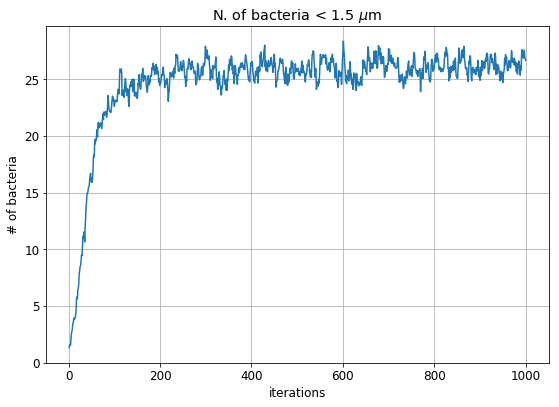

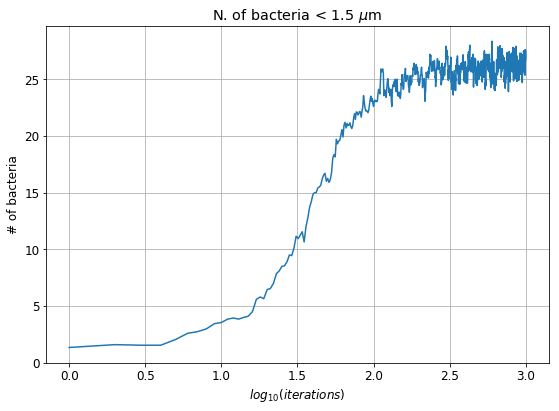

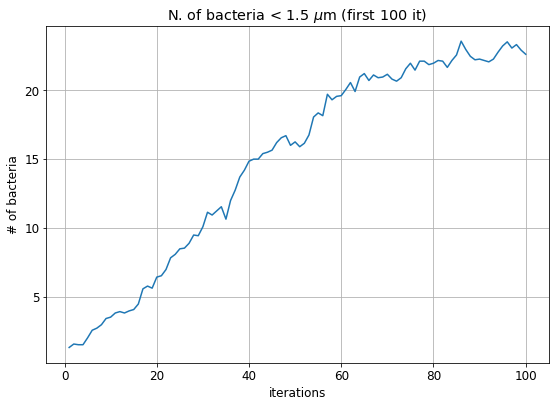

In [248]:
mpl.rcParams['figure.figsize']=(9.0,6.0)    #(6.0,4.0)

x = np.arange(1, density.size+1,1)

plt.figure()
plt.plot(x,density/nexp)
plt.grid(True)
plt.title("N. of bacteria < 1.5 $\mu$m")
plt.xlabel("iterations")
plt.ylabel("# of bacteria")


plt.figure()
plt.plot(np.log10(x),density/nexp)
plt.grid(True)
plt.title("N. of bacteria < 1.5 $\mu$m")
plt.xlabel("$log_{10}(iterations)$")
plt.ylabel("# of bacteria")

plt.figure()
plt.plot(x[:100],(density/nexp)[:100])
plt.grid(True)
plt.title("N. of bacteria < 1.5 $\mu$m (first 100 it)")
plt.xlabel("iterations")
plt.ylabel("# of bacteria")


plt.show()

The result is very interesting, as the norm of the speed is constant the bacteria can not stabilize at the center and start to "orbit" around it. In this way the number of bacteria close to the center grow linearly until saturate around 25 (as visible in both logartmic scale and in the first 100 iterations plot).


### Non-continuos density

I also experimented with a non-continuos density in the form of:
$$\rho(\bar(x)) = \begin{cases} 1 & |\bar{x}-\bar{c}|<15\mu m \\ 0 &  |\bar{x}-\bar{c}|\geq 15\mu m\end{cases}$$

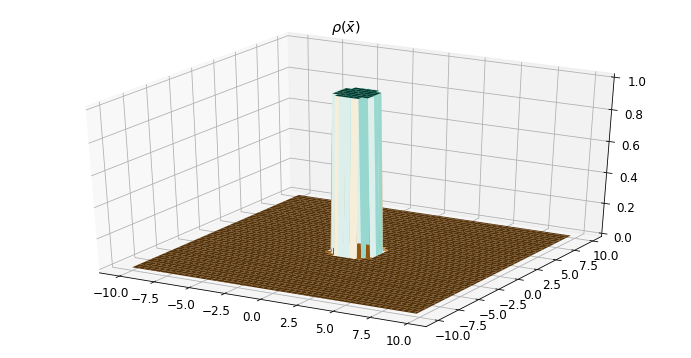

In [268]:

__CENTER__ = np.array([0, 0])
N = 100
DS = __SIZE__*2/(N)
FOOD = np.zeros([N, N])
for i in range(N):
    x = i*DS-__SIZE__
    for j in range(N):
        y = j*DS-__SIZE__
        FOOD[i, j] = __uni_density__([x, y], __CENTER__)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X = np.arange(-__SIZE__, __SIZE__, DS)
Y = np.arange(-__SIZE__, __SIZE__, DS)

X, Y = np.meshgrid(X, Y)
ax.plot_surface(X,Y,FOOD, cmap='BrBG')
plt.title(r"$\rho(\bar{x})$")
plt.show()

### 100 Bacteria and non-continuos density

I then re-did the same experiment of before (population of 100 bacterias) with this new density distribution:

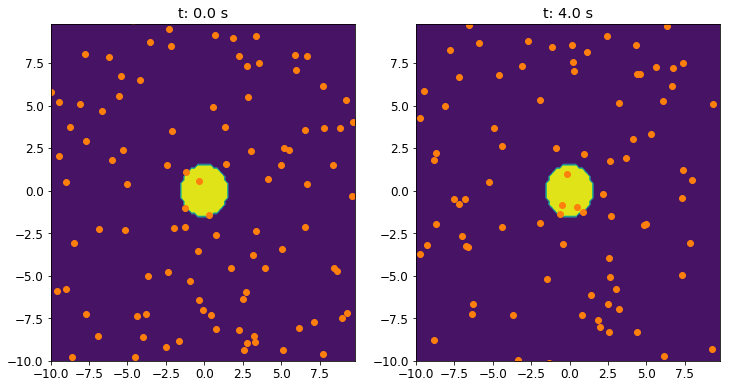

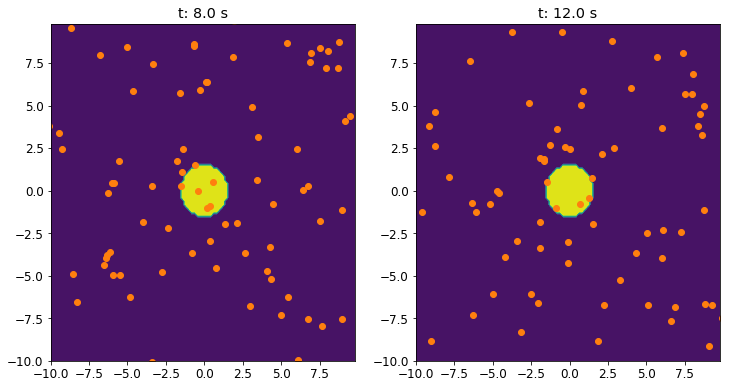

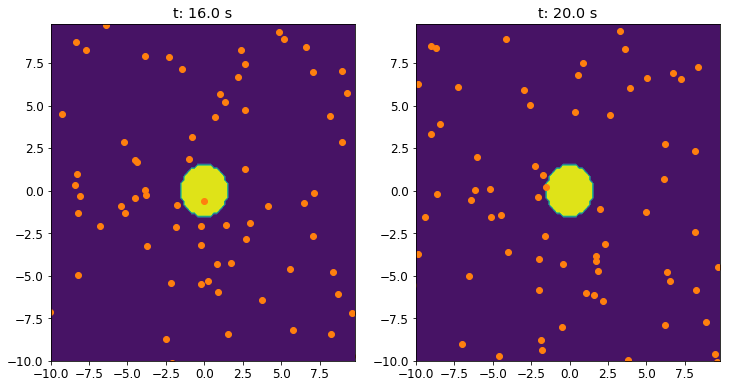

In [269]:
mpl.rcParams['figure.figsize']=(12.0,6.0)    #(6.0,4.0)

__NBACT__ = 100
__ITER__ = 100
__SIZE__ = 10
__DT__ = 0.2

AGENTS = __init_bacteria__(__NBACT__, __SIZE__)

plt.figure()
plt.subplot(121)
plt.contourf(X,Y,FOOD, 10)
__plot__(AGENTS)
plt.xlim([np.min(X), np.max(X)])
plt.ylim([np.min(Y), np.max(Y)])
plt.title("t: 0.0 s")

for it in range(0, __ITER__):
    for ag in AGENTS:
        ag.move(__DT__)
        ag.update(__uni_density__(ag.pos, __CENTER__))

        
    if (it+1)%20 == 0: 
        if (it+1)/20 %2:
            plt.subplot(122)
        else:
            plt.figure()
            plt.subplot(121)
        plt.contourf(X,Y,FOOD, 10)
        __plot__(AGENTS)
        plt.xlim([np.min(X), np.max(X)])
        plt.ylim([np.min(Y), np.max(Y)])
        plt.title("t: {:0.1f} s".format((it+1)*__DT__))

plt.show()


At first view it seems that as the bacterias have constant speed and the nutrtion density is distributed uniformly in the 2 areas of our simulation the bacteria are not able to be attracted by the source of food.
The stathistical analysis of the center of the simulation confirmed my hypotesis:

In [271]:
import sys
nexp  = 20
__ITER__ = 1000
r = 1.5

density = np.zeros(__ITER__)
for i in range(nexp):
    sys.stdout.write("\r {}/{}".format(i+1, nexp))
    sys.stdout.flush()
    AGENTS = __init_bacteria__(__NBACT__, __SIZE__)
    for it in range(0, __ITER__):
        for ag in AGENTS:
            ag.move(__DT__)
            ag.update(__uni_density__(ag.pos, __CENTER__))
            if np.linalg.norm(ag.pos-__CENTER__,2) <= r:
                density[it]+=1

print()

 20/20


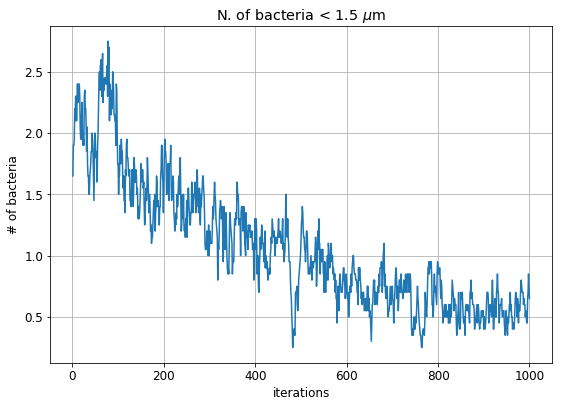

In [272]:
mpl.rcParams['figure.figsize']=(9.0,6.0)    #(6.0,4.0)

x = np.arange(1, density.size+1,1)

plt.figure()
plt.plot(x,density/nexp)
plt.grid(True)
plt.title("N. of bacteria < 1.5 $\mu$m")
plt.xlabel("iterations")
plt.ylabel("# of bacteria")



plt.show()

As the attraction to the food is not efficent in this case in the long run the number of bacteria at the center tend to 0.

### Actracted Bacteria

Then we were asked to implement a new movment function to the bacteria in a way that they would be actracted not only by the nutrients but as well by the other bacteria (only if the distance is $\leq 10\mu m$).

After implementing this new move function, I chose to redo the 100 bacteria experiment with continuos density distribution and the new move function:



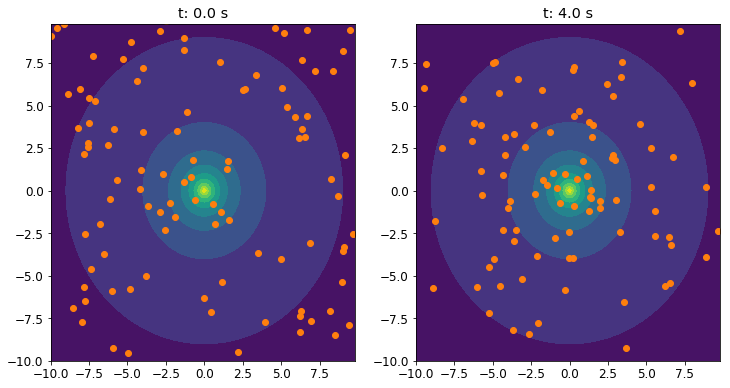

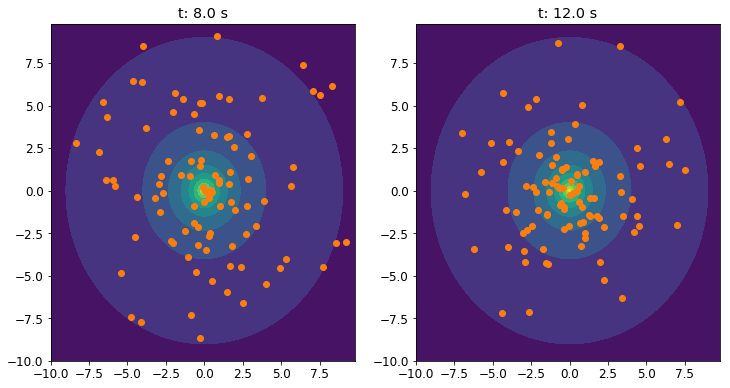

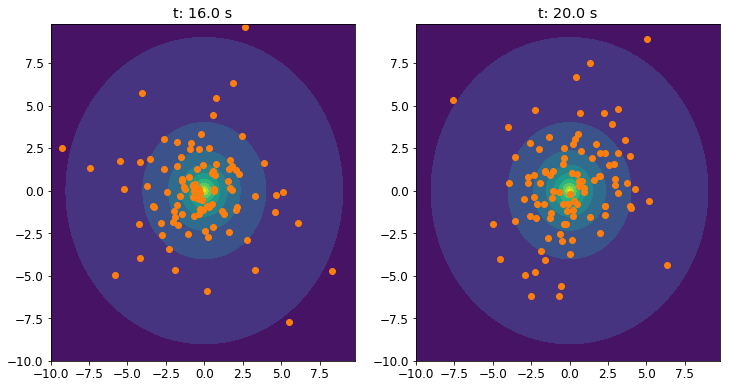

In [310]:
mpl.rcParams['figure.figsize']=(12.0,6.0)    #(6.0,4.0)

__CENTER__ = np.array([0, 0])
N = 100
DS = __SIZE__*2/(N)
FOOD = np.zeros([N, N])
for i in range(N):
    x = i*DS-__SIZE__
    for j in range(N):
        y = j*DS-__SIZE__
        FOOD[i, j] = __density__([x, y], __CENTER__)

__NBACT__ = 100
__ITER__ = 100
__SIZE__ = 10
__DT__ = 0.2

AGENTS = __init_bacteria__(__NBACT__, __SIZE__)

plt.figure()
plt.subplot(121)
plt.contourf(X,Y,FOOD, 10)
__plot__(AGENTS)
plt.xlim([np.min(X), np.max(X)])
plt.ylim([np.min(Y), np.max(Y)])
plt.title("t: 0.0 s")

for it in range(0, __ITER__):
    for ag in AGENTS:
        ag.n_move(AGENTS, __DT__)
        ag.update(__density__(ag.pos, __CENTER__))

        
    if (it+1)%20 == 0:
        if (it+1)/20 % 2:
            plt.subplot(122)
        else:
            plt.figure()
            plt.subplot(121)
        plt.contourf(X,Y,FOOD, 10)
        __plot__(AGENTS)
        plt.xlim([np.min(X), np.max(X)])
        plt.ylim([np.min(Y), np.max(Y)])
        plt.title("t: {:0.1f} s".format((it+1)*__DT__))

plt.show()


As the $\alpha$ parameter (that control the actraction) chosen is small at first view there is no big difference. However the statistics (and longer simulations) show clearly the impact of this actraction:

In [311]:
import sys
nexp  = 3
__ITER__ = 500
r = 1.5

density = np.zeros(__ITER__)
for i in range(nexp):
    sys.stdout.write("\r {}/{}".format(i+1, nexp))
    sys.stdout.flush()
    AGENTS = __init_bacteria__(__NBACT__, __SIZE__)
    for it in range(0, __ITER__):
        for ag in AGENTS:
            ag.n_move(AGENTS, __DT__)
            ag.update(__density__(ag.pos, __CENTER__))
            if np.linalg.norm(ag.pos-__CENTER__,2) <= r:
                density[it]+=1

print()

 3/3


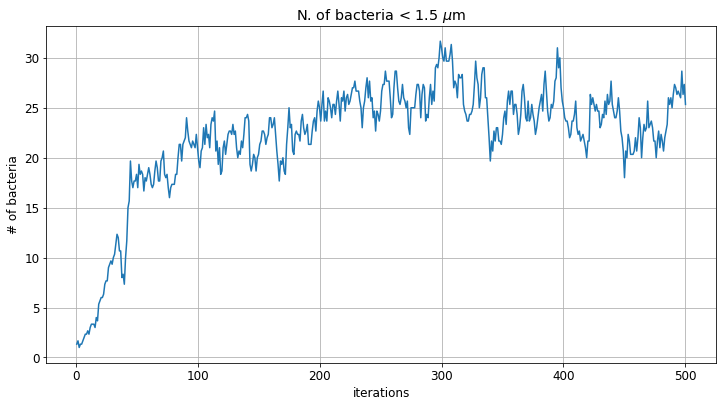

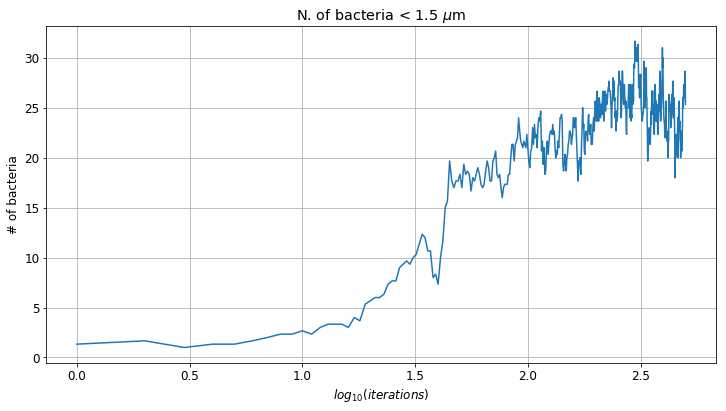

In [312]:

x = np.arange(1, density.size+1,1)

plt.figure()
plt.plot(x,density/nexp)
plt.grid(True)
plt.title("N. of bacteria < 1.5 $\mu$m")
plt.xlabel("iterations")
plt.ylabel("# of bacteria")


plt.figure()
plt.plot(np.log10(x),density/nexp)
plt.grid(True)
plt.title("N. of bacteria < 1.5 $\mu$m")
plt.xlabel("$log_{10}(iterations)$")
plt.ylabel("# of bacteria")



plt.show()

In the longer run it appeara that the saturation limit is higher as the attraction tent to concentrate the bacteria and to controbalance the constant speed problem.

### Parallelization

As last teorethical question we were asked a what could be a possible way to implement a parallel version of this multi-agent simulation.

Without atraction the answare is very simple, as there is no interaction between different bacterias, the agents could be divided in $N$ groups (one per processor) and the simulation of this $N$ groups could be done indipendently. 

However whit the attraction the problem is more complex. With a big number of bacteria some sort of parallel Barnes-Hut algorithm should be the optimal solution, in order to minimize the inter-processors messages the closest bacteria are simulated togheter and the use of the tree structure should permit to minimize the number of messages.

With smaller number of bacteria a simple division of the space in grid should be enough (and parallel simulation of each area).